In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import lightgbm
from keras import optimizers
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from sklearn.decomposition import PCA
import skimage.io
from skimage.io import imread
import pprint, pickle

In [3]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(os.path.join('..', 'cancer_classifier'), '*', '*.jpg'))}

In [5]:
len(imageid_path_dict)

10015

In [6]:
lesions = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [21]:
df = pd.read_csv(os.path.join(os.path.join('..', 'cancer_classifier'), 'HAM10000_metadata.csv')) #links image csv with main path
df['path'] = df['image_id'].map(imageid_path_dict.get) #links image path with df
df['cell_type'] = df['dx'].map(lesions.get) #combines with dictionary
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes #converts the lession types to categorical

In [22]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../cancer_classifier/HAM10000_images_part_2/IS...,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0


In [23]:
df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx'],
      dtype='object')

In [24]:
df.dtypes

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object

In [25]:
df['age'].fillna((df['age'].mean()), inplace=True) #replace all null age with mean of population age
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [2]:
# df.to_csv('2cancercell.csv', index=False)
df= pd.read_csv('2cancercell.csv')
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../cancer_classifier/HAM10000_images_part_2/IS...,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0


In [29]:
df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0005263,ISIC_0024870,nv,histo,male,back,../cancer_classifier/HAM10000_images_part_1/IS...,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


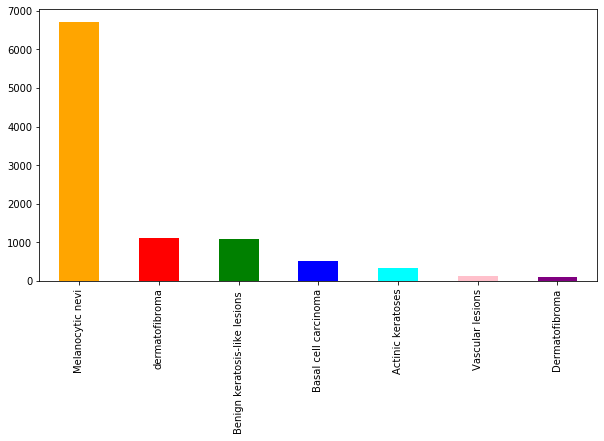

In [30]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
df['cell_type'].value_counts().plot(kind='bar', color=['orange', 'red', 'green', 'blue', 'cyan', 'pink', 'purple'])

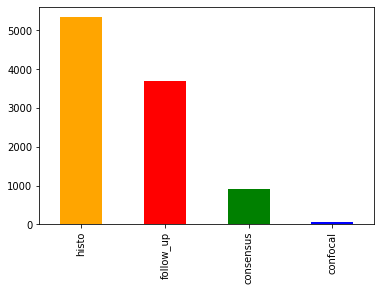

In [31]:
df['dx_type'].value_counts().plot(kind='bar', color=['orange', 'red', 'green', 'blue'])

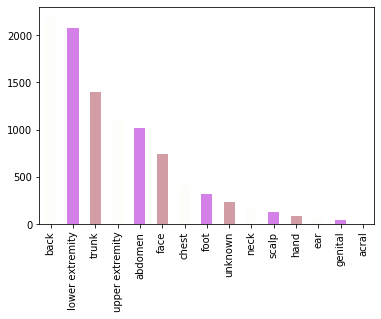

In [32]:
df['localization'].value_counts().plot(kind='bar', color=np.random.rand(3,4))

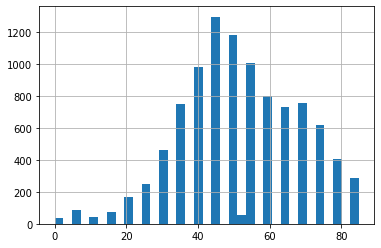

In [33]:
df['age'].hist(bins=35)

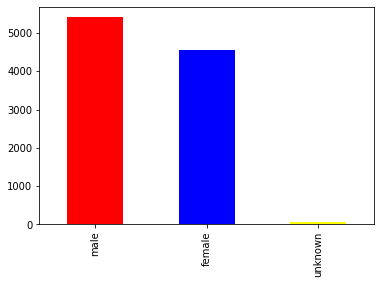

In [34]:
df['sex'].value_counts().plot(kind='bar', color=['red', 'blue', 'yellow'])

In [5]:
#load up all images in a separate df
images= df['path'].map((imread))
#convert dtypes to numpy array
images= skimage.io.concatenate_images(images)
images

array([[[[188, 147, 191],
         [186, 148, 189],
         [187, 150, 191],
         ...,
         [196, 155, 171],
         [197, 156, 170],
         [197, 157, 168]],

        [[186, 149, 193],
         [187, 152, 194],
         [189, 153, 191],
         ...,
         [194, 156, 169],
         [195, 159, 169],
         [192, 159, 168]],

        [[185, 148, 192],
         [189, 152, 195],
         [190, 153, 196],
         ...,
         [196, 155, 169],
         [198, 157, 171],
         [194, 156, 169]],

        ...,

        [[157, 124, 155],
         [156, 121, 154],
         [159, 124, 154],
         ...,
         [177, 146, 161],
         [176, 144, 159],
         [175, 141, 155]],

        [[155, 122, 151],
         [156, 123, 154],
         [156, 123, 152],
         ...,
         [178, 147, 163],
         [175, 144, 159],
         [175, 142, 159]],

        [[154, 119, 151],
         [153, 120, 149],
         [154, 121, 152],
         ...,
         [176, 147, 167],
        

In [10]:
#save the image array into a pickle
output = open('image.pkl', 'wb') #write a file larger than 4 gb
pickle.dump(images, output, protocol=4)
output.close()

In [11]:
#t0 read the file again:
pkl_file = open('image.pkl', 'rb') #read

images = pickle.load(pkl_file)

pkl_file.close()

array([[[[188, 147, 191],
         [186, 148, 189],
         [187, 150, 191],
         ...,
         [196, 155, 171],
         [197, 156, 170],
         [197, 157, 168]],

        [[186, 149, 193],
         [187, 152, 194],
         [189, 153, 191],
         ...,
         [194, 156, 169],
         [195, 159, 169],
         [192, 159, 168]],

        [[185, 148, 192],
         [189, 152, 195],
         [190, 153, 196],
         ...,
         [196, 155, 169],
         [198, 157, 171],
         [194, 156, 169]],

        ...,

        [[157, 124, 155],
         [156, 121, 154],
         [159, 124, 154],
         ...,
         [177, 146, 161],
         [176, 144, 159],
         [175, 141, 155]],

        [[155, 122, 151],
         [156, 123, 154],
         [156, 123, 152],
         ...,
         [178, 147, 163],
         [175, 144, 159],
         [175, 142, 159]],

        [[154, 119, 151],
         [153, 120, 149],
         [154, 121, 152],
         ...,
         [176, 147, 167],
        

In [12]:
images

array([[[[188, 147, 191],
         [186, 148, 189],
         [187, 150, 191],
         ...,
         [196, 155, 171],
         [197, 156, 170],
         [197, 157, 168]],

        [[186, 149, 193],
         [187, 152, 194],
         [189, 153, 191],
         ...,
         [194, 156, 169],
         [195, 159, 169],
         [192, 159, 168]],

        [[185, 148, 192],
         [189, 152, 195],
         [190, 153, 196],
         ...,
         [196, 155, 169],
         [198, 157, 171],
         [194, 156, 169]],

        ...,

        [[157, 124, 155],
         [156, 121, 154],
         [159, 124, 154],
         ...,
         [177, 146, 161],
         [176, 144, 159],
         [175, 141, 155]],

        [[155, 122, 151],
         [156, 123, 154],
         [156, 123, 152],
         ...,
         [178, 147, 163],
         [175, 144, 159],
         [175, 142, 159]],

        [[154, 119, 151],
         [153, 120, 149],
         [154, 121, 152],
         ...,
         [176, 147, 167],
        

In [ ]:
#  pd.DataFrame(list(map(np.ravel, list_arrays)))
images= pd.DataFrame(list(map(np.ravel, images)))